# Smooth Sparse Invariance

## Intro
* **Date**: 1/5/2021
* **What**: This is a network with an invariant layer that explicity alters its weights so that its output matches the linear interpolation of the output throughout time.  I need this to be smooth, baby.
* **Why**: I need this to be smooth, baby.  Basically, I was trying to do all the training of the invariant layer using reconstruction error, but I was doing it pretty stupidly, and there actually isn't a ton of information coming from the sparse layer at any given moment.  So basically, it wasn't working.  This time, I'm training the invariant layer both with reconstruction error and linear-interpolation error.  The former ensures the output is normalized, and the later should hopefully create the smoothing I need to see.
* **Hopes**: I want my invariant layer to work.
* **Limitations**: I really don't even know.  Actually one big limitation is that there simply isn't a ton of information coming from the sparse layer, so it might take a *really* long time for the invariant layer to get smooth.  Hopefully not, but it's a concern.  

Again, it's pretty exciting to think that I don't even know how this is going to fail.  And then I will, and then I'll fix it.  Dope!

## Code

In [1]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tensorflow.keras.datasets import mnist
from tqdm import tqdm

(x_tr, _), _ = mnist.load_data()

x_tr = x_tr / 255.0

t_sl = 30 # Tapestry side length
m_sl = 28 # Side length of each images

tapestry = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 3000

for x in range(t_sl):
    for y in range(t_sl):

        tapestry[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tapestry[(t_sl - 1) * m_sl:, :] = tapestry[: m_sl, :]
tapestry[:, (t_sl - 1) * m_sl:] = tapestry[:, : m_sl]

def draw_weights(w, Kx, Ky, s_len, fig):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)
    fig.colorbar(im, ticks=[0, max_val])
    plt.axis("off")
    fig.canvas.draw()

In [2]:
def draw_weights_no_colorbar(w, Kx, Ky, s_len):
    tapestry = np.zeros((s_len * Ky, s_len * Kx))
    
    w_i = 0
    for y in range(Ky):
        for x in range(Kx):
            tapestry[y * s_len: (y + 1) * s_len, x * s_len: (x + 1) * s_len] = w[w_i].reshape(s_len, s_len)
            w_i += 1
            
    plt.clf()        
    max_val = np.max(tapestry)
    im = plt.imshow(tapestry, cmap="Greys", vmax=max_val)

In [3]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 100_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_data = img_array.reshape(-1, sl ** 2)
gp_data = cp.asarray(ts_data)

<IPython.core.display.Javascript object>


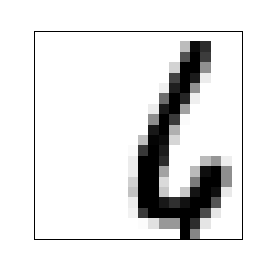

In [4]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

In [5]:
tap_val = np.zeros((t_sl * m_sl, t_sl * m_sl))

x_i = 10000

for x in range(t_sl):
    for y in range(t_sl):

        tap_val[y * m_sl : (y + 1) * m_sl, x * m_sl : (x + 1) * m_sl] = x_tr[x_i]
        x_i += 1
        
tap_val[(t_sl - 1) * m_sl:, :] = tap_val[: m_sl, :]
tap_val[:, (t_sl - 1) * m_sl:] = tap_val[:, : m_sl]

In [6]:
x_o = 420
y_o = 420

sl = 20

x = x_o
y = y_o

v_x = 0
v_y = 0

v_max = 3

a_x = np.random.uniform(-1, 1)
a_y = np.random.uniform(-1, 1)

img_count = 10_000
imgs = []

del_t = 1

for i in range(img_count):
    if i % 20 == 0:
        a_x = np.random.uniform(-1, 1)
        a_y = np.random.uniform(-1, 1)
        
    x += v_x * del_t
    y += v_y * del_t
    v_x = np.clip(v_x + (a_x * del_t), -v_max, v_max)
    v_y = np.clip(v_y + (a_y * del_t), -v_max, v_max)
    
    x_f = int(x) % ((t_sl - 1) * m_sl)
    y_f = int(y) % ((t_sl - 1) * m_sl)
    
    imgs.append(tapestry[y_f: y_f + sl, x_f : x_f + sl])
    
img_array = np.array(imgs)
ts_val = img_array.reshape(-1, sl ** 2)
gp_val = cp.asarray(ts_data)

<IPython.core.display.Javascript object>


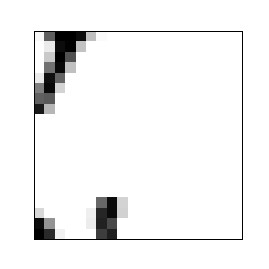

In [7]:
%matplotlib notebook
fig = plt.figure(figsize=(3, 3))

ims = []
for i in range(500):
    im = plt.imshow(imgs[i], cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=100, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])
plt.show()

## Analysis Dialog

Here we go!  I'm going to start with 400 sparse neurons, and 100 invariant neurons.

<IPython.core.display.Javascript object>


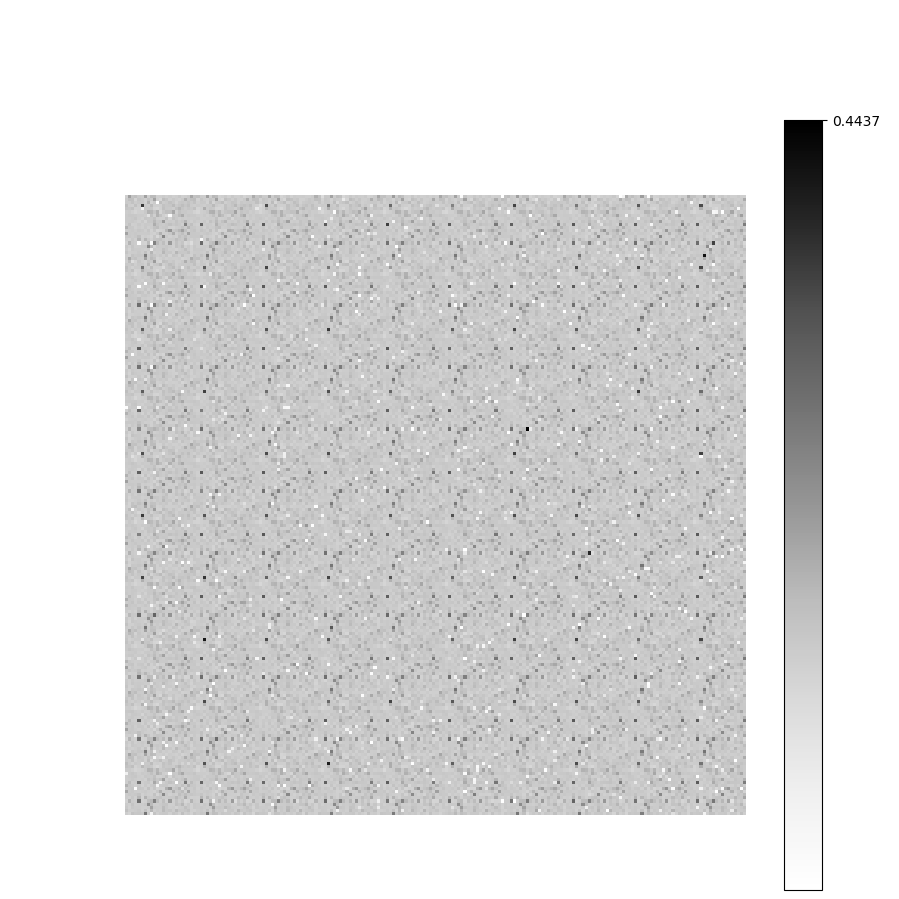

 26%|██▋       | 2634/10000 [00:03<00:09, 775.60it/s]


KeyboardInterrupt: 

In [8]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 20
Ky = 20
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.01

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

in_w = 10 #Number of winners in the invariant layer

iw = cp.random.uniform(0, 1, (iN, sN))
eta = 0.1
zeta = 0.05


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    so_b = cp.zeros((sN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        p = iw @ so
        winners = cp.argsort(p, axis=0)[-in_w:]
        mask = cp.zeros((iN, 1))
        mask[winners] = 1
        io = mask * p
        
        io_p = (io + io_bb) / 2

        # Train for smoothness in time
        iw += iw * (io_p - io_b) * (so_b).T * eta

        # Train for reconstruction ability
        r = iw.T @ io
        mod_r = cp.maximum(r, prec)
        e = cp.where(so > 0, so - r, 0)

        iw += iw * io * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io
        
        so_b = so

    if (ep // 2) % 2:
        draw_weights(iw.get(), Ix, Iy, Kx, fig)
    else:
        draw_weights(sw.get(), Kx, Ky, sl, fig)

Uh-oh.  The invariant prototypes are looking super homogenous.  Let's look an the animation:

<IPython.core.display.Javascript object>


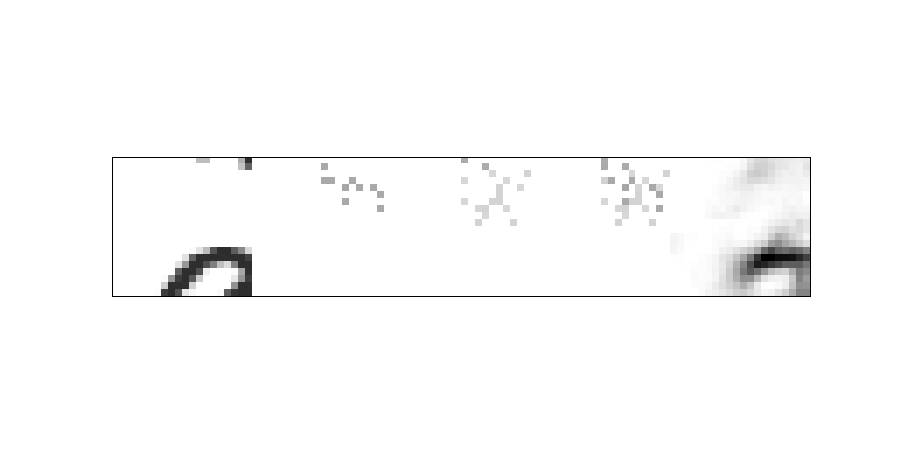

100%|██████████| 500/500 [00:00<00:00, 549.18it/s]


In [9]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    p = iw_np @ so
    winners = np.argsort(p, axis=0)[-in_w:]
    mask = np.zeros((iN, 1))
    mask[winners] = 1
    io = mask * p

    io_p = (io + io_bb) / 2

    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io_bb.reshape(glee, glee)
    mini_tap[:glee, 60 - glee:60] = io_p.reshape(glee, glee)
    mini_tap[:glee, 80 - glee:80] = np.abs(io_bb - io_p).reshape(glee, glee) 
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=200, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

Ugh.  That's so very bad.  I'm going to nerf the learning constants, and watch what happens only to the invariant layer.

<IPython.core.display.Javascript object>


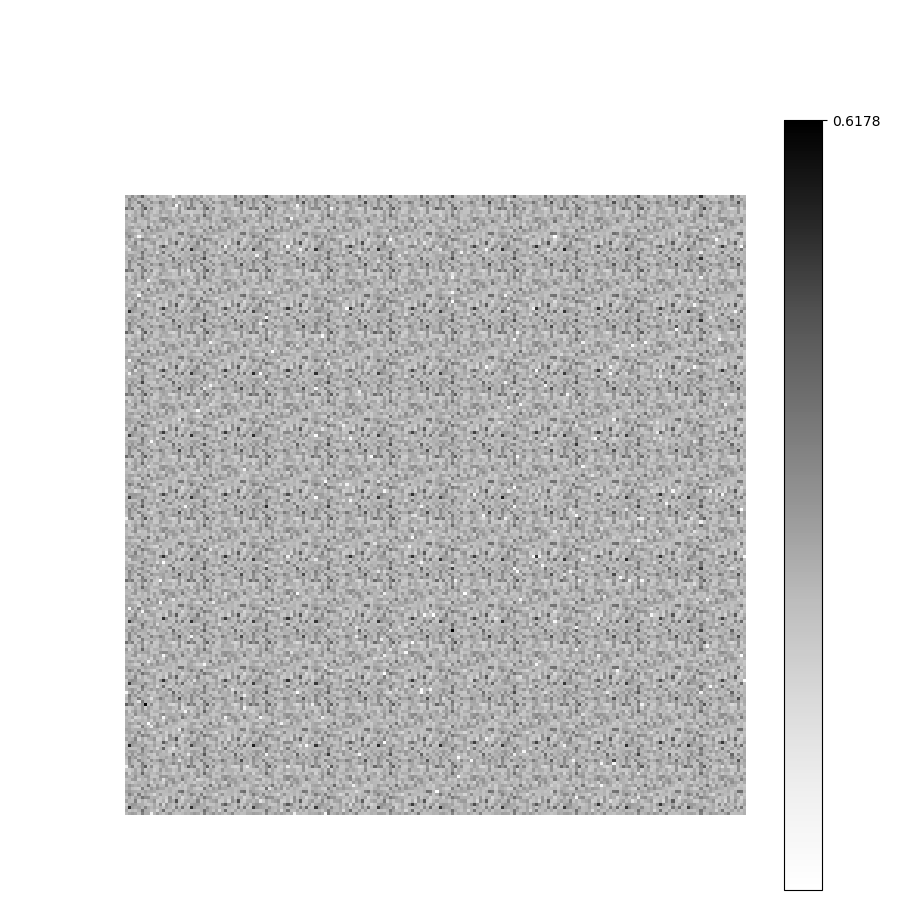

  7%|▋         | 729/10000 [00:00<00:09, 982.17it/s] 


KeyboardInterrupt: 

In [11]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 10))

Nep = 20
T_s = 10000
prec = 1e-10

# Sparse Layer
Kx = 20
Ky = 20
sN = Kx * Ky
m_len = sl ** 2

n_w = 5 #Number of winners

sw = cp.random.uniform(0, 0.2, (sN, m_len))
xi = 0.01

# Invariant Layer
Ix = 10
Iy = 10
iN = Ix * Iy

in_w = 10 #Number of winners in the invariant layer

iw = cp.random.uniform(0, 1, (iN, sN))
eta = 0.1
zeta = 0.05


for ep in range(Nep):
    inputs = gp_data
    
    io_bb = cp.zeros((iN, 1))
    io_b = cp.zeros((iN, 1))
    
    so_b = cp.zeros((sN, 1))
    
    for i in tqdm(range(T_s)):

        # Handle sparse layer
        v = inputs[i].reshape(-1, 1)
        p = sw @ v
        winners = cp.argsort(p, axis=0)[-n_w:]
        mask = cp.zeros((sN, 1))
        mask[winners] = 1
        so_uw = mask * p
        r = sw.T @ so_uw
        mod_r = cp.maximum(r, prec)
        e = v - r

        sw += sw * so_uw * (e / mod_r).T * xi

        so = so_uw / cp.sum(sw, axis=1).reshape(-1, 1)

        # Handle invariant layer
        p = iw @ so
        winners = cp.argsort(p, axis=0)[-in_w:]
        mask = cp.zeros((iN, 1))
        mask[winners] = 1
        io = mask * p
        
        io_p = (io + io_bb) / 2

        # Train for smoothness in time
        iw += iw * (io_p - io_b) * (so_b).T * eta

        # Train for reconstruction ability
#         r = iw.T @ io
#         mod_r = cp.maximum(r, prec)
#         e = cp.where(so > 0, so - r, 0)

#         iw += iw * io * (e / mod_r).T * zeta

        io_bb = io_b
        io_b = io
        
        so_b = so
        
    draw_weights(iw.get(), Ix, Iy, Kx, fig)

#     if (ep // 2) % 2:
#         draw_weights(iw.get(), Ix, Iy, Kx, fig)
#     else:
#         draw_weights(sw.get(), Kx, Ky, sl, fig)

Ok, so the smoothing rule is creating homogeneity.  Great.  Here's the simulation.

<IPython.core.display.Javascript object>


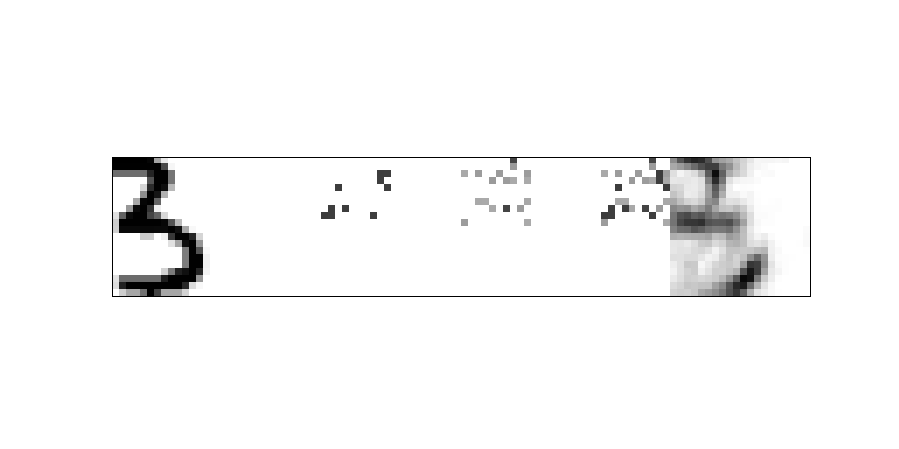

100%|██████████| 500/500 [00:00<00:00, 517.46it/s]


In [13]:
%matplotlib notebook
fig = plt.figure(figsize=(10, 5))

sw_np = sw.get()
iw_np = iw.get()

ims = []

io_b = np.zeros((iN, 1))
io_bb = np.zeros((iN, 1))


for i in tqdm(range(500)):
    # Handle sparse layer
    v = ts_data[i].reshape(-1, 1)
    p = sw_np @ v
    winners = np.argsort(p, axis=0)[-n_w:]
    mask = np.zeros((sN, 1))
    mask[winners] = 1
    so_uw = mask * p
    r = sw_np.T @ so_uw
    mod_r = np.maximum(r, prec)
    e = v - r

    so = so_uw / np.sum(sw_np, axis=1).reshape(-1, 1)

    # Handle invariant layer
    p = iw_np @ so
    winners = np.argsort(p, axis=0)[-in_w:]
    mask = np.zeros((iN, 1))
    mask[winners] = 1
    io = mask * p

    io_p = (io + io_bb) / 2

    io_bb = io_b
    io_b = io
    
    mini_tap = np.zeros((20, 100))
    
    glee = 10
    
    mini_tap[:, :20] = v.reshape(20, 20)
    mini_tap[:glee, 40 - glee:40] = io_bb.reshape(glee, glee)
    mini_tap[:glee, 60 - glee:60] = io_p.reshape(glee, glee)
    mini_tap[:glee, 80 - glee:80] = np.abs(io_bb - io_p).reshape(glee, glee) 
    mini_tap[:, -20:] = r.reshape(20, 20)
    
    im = plt.imshow(mini_tap, cmap="gray_r", animated=True)
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=500, blit=True,
                                repeat_delay=500)

plt.xticks([])
plt.yticks([])

plt.show()

## Conclusions

I don't think it's going to be smooth unless I force it to be smooth.  This is actually super weird. How do I get the network to learn to be smooth?  I might need to take another peek at Yubei's paper.  

Yeah, I think I might need to move heaven and earth to make the invariant layer smooth. Great.

## Next steps

First I'm going to sleep for a little bit because I think my brain isn't working properly at the moment, then I'm going to try to think up how to make the invariant layer smooth in a meaningful way.